# Titanic Survival Prediction: Final score of .78947

## 1.) Introduction

This project will try to predict the likelihood of survival for passengers on the Titanic.

### 1A.) Import Libraries

In [1]:
import sklearn  # Machine learning library
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Data visualization
import numpy as np  # Linear Algebra
import pandas as pd  # Pandas for data frames
import warnings
from sklearn.ensemble import StackingClassifier  # Final ensemble model
from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting
from sklearn.neighbors import KNeighborsClassifier  # KNearestNeighbors
from sklearn.ensemble import RandomForestClassifier  # Random Forests
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.model_selection import train_test_split, cross_val_score  # Splitting training and validation data
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve  # ROC curve plotting
from sklearn.metrics import classification_report  # Classification report matrix
from sklearn.preprocessing import power_transform  # Box cox transformation
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import xgboost as xgb

# Future Warning in front of plots was annoying.
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style="whitegrid")
sns.set_context(context=None, font_scale=1, rc=None)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 24

## 2.) Loading Data

In [2]:
titanic = pd.read_csv('train.csv')  # Read in training dataset
test = pd.read_csv('test.csv')  # Read in testing dataset

### 2B.) Functions to make life easier

In [3]:
def make_probability_chart(dataframe, target, column):
    """Makes a bar chart showing survival rate by target variable"""
    f, ax = plt.subplots(figsize=(12, 8))
    dataframe.groupby([column])[target].mean().plot(kind='bar')
    plt.title(f'{target} by {column}')
    plt.ylabel(f"Probability of {target}")
    xvals = ax.get_xticks()
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in yvals])
    f.autofmt_xdate()
    plt.show()


def make_roc_auc_chart(model_name, y_true, y_pred):
    """Plots an ROC/AUC curve for a given model"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.show()

## 3.) Exploratory Data Analysis

### 3A.) First Glance

In [4]:
# First few rows
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Shape of dataset (rows, columns)
titanic.shape

(891, 12)

### 3B.) Survived

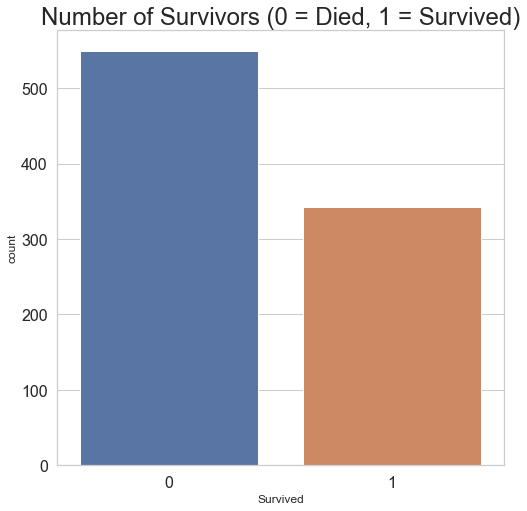

In [6]:
# Create a bar chart showing number of survivors.
f, ax = plt.subplots(figsize=(8, 8))
nsurvivors = sns.countplot(titanic['Survived']).set_title(
    'Number of Survivors (0 = Died, 1 = Survived)')
plt.show()

### 3C.) Passenger Class

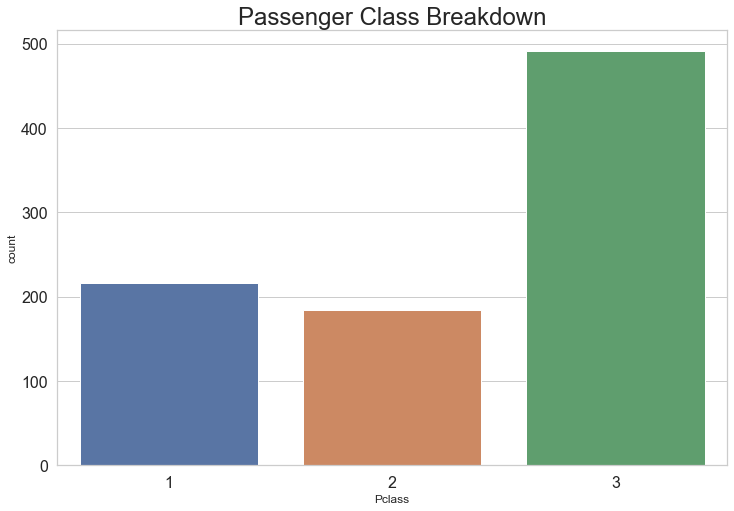

In [7]:
# Updating Color Palatte

plt.subplots(figsize=(12, 8))
sns.countplot(titanic['Pclass']).set_title('Passenger Class Breakdown')
plt.show()

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


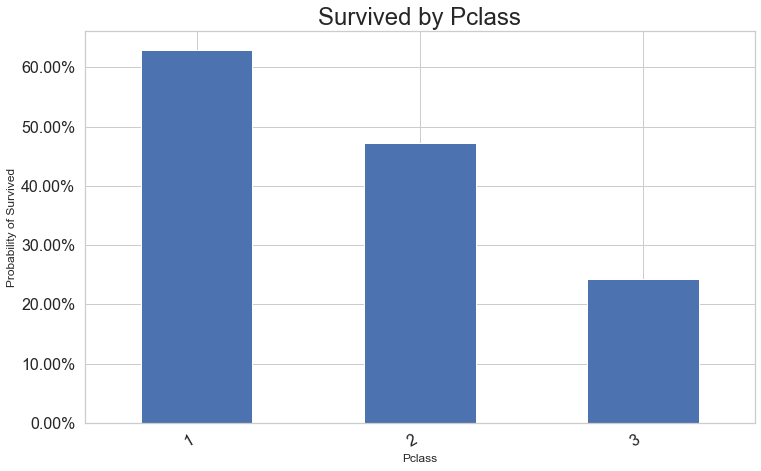

In [8]:
make_probability_chart(titanic, "Survived", "Pclass")

### 3D.) Name

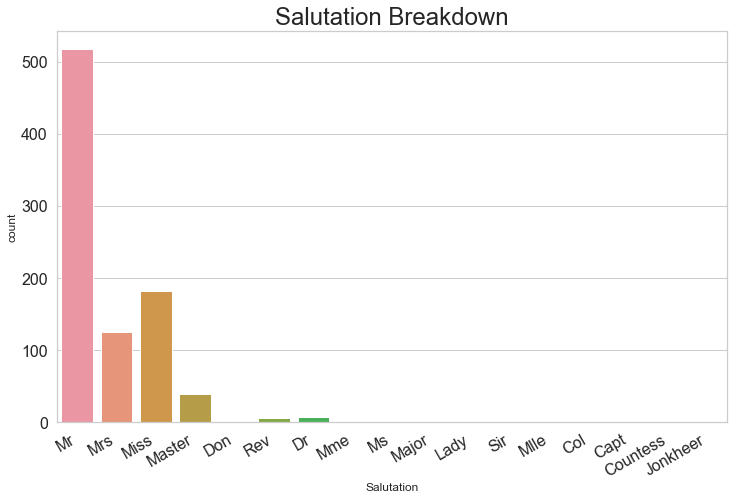

In [9]:
titanic['Salutation'] = titanic['Name'].str.extract('([A-Za-z]+)\.')
test['Salutation'] = test['Name'].str.extract('([A-Za-z]+)\.')

f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(titanic['Salutation']).set_title('Salutation Breakdown')
f.autofmt_xdate()
plt.show()

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


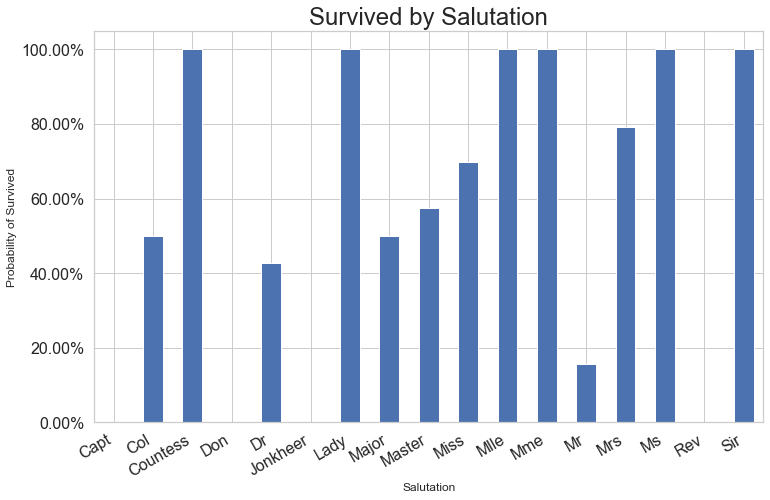

In [10]:
make_probability_chart(titanic, "Survived", "Salutation")

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


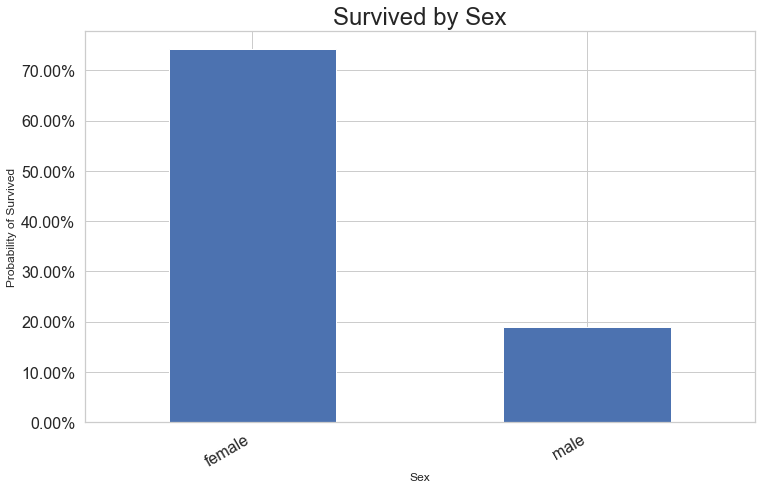

In [11]:
make_probability_chart(titanic, "Survived", "Sex")

### 3F.) Age

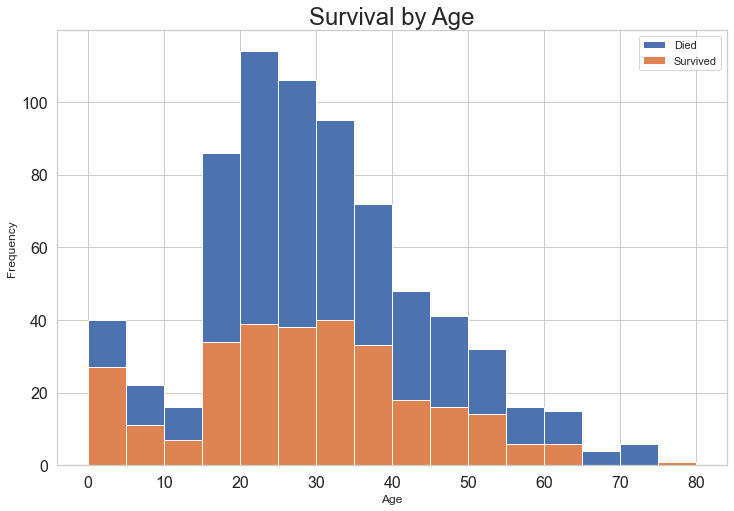

In [12]:
# Create a stacked histogram to show survival by age.
f, ax = plt.subplots(figsize=(12, 8))
titanic['Age'].plot.hist(bins=range(0, 85, 5))
age_plot = titanic[titanic['Survived'] == 1]['Age'].plot.hist(
    bins=range(0, 85, 5))
age_plot.legend(['Died', 'Survived'])
age_plot.set_title('Survival by Age')
age_plot.set_xlabel('Age')
plt.show()

titanic['Infant'] = titanic['Age'] <= 1
test['Infant'] = titanic['Age'] <= 1
titanic['Child'] = titanic['Age'] <= 18
test['Child'] = test['Age'] <= 18
titanic['Elder'] = titanic['Age'] >= 55
test['Elder'] = titanic['Age'] >= 55

### 3G.) Family

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


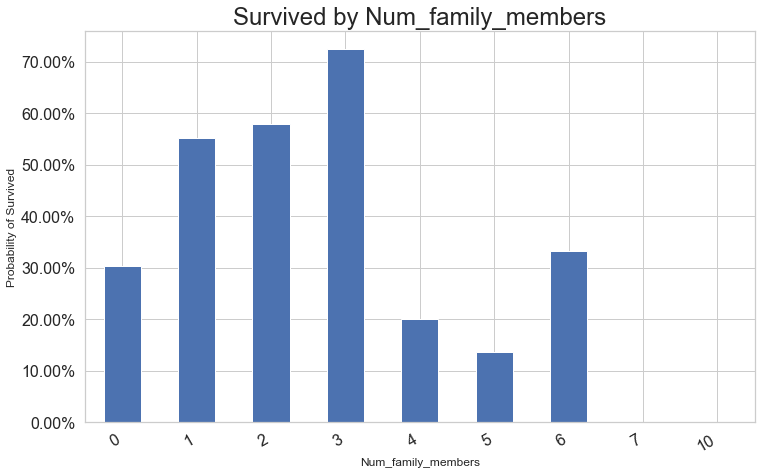

In [13]:
# Combining siblings and parents into family
titanic['Num_family_members'] = titanic['SibSp'] + titanic['Parch']
test['Num_family_members'] = test['SibSp'] + titanic['Parch']

titanic['large_family'] = titanic['Num_family_members'] >= 4
test['large_family'] = test['Num_family_members'] >= 4

make_probability_chart(titanic, "Survived", "Num_family_members")

### 3H.) Cabin

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


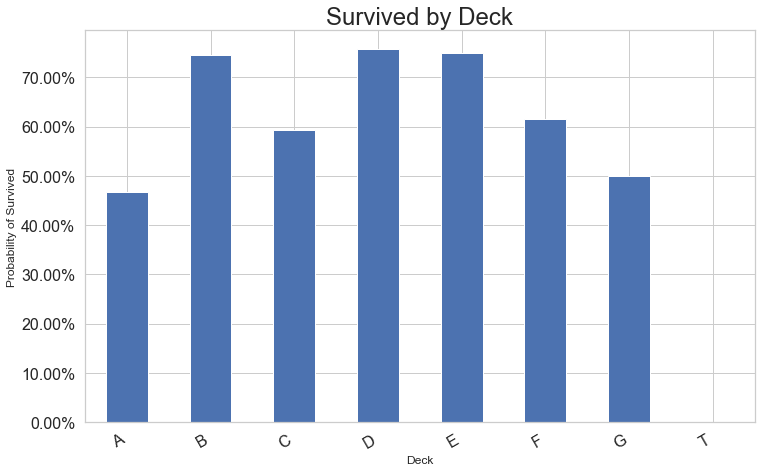

In [14]:
# Replaced cabins with a deck. NaNs for level have 'n'.
titanic['Deck'] = titanic['Cabin'].str[0]
test['Deck'] = test['Cabin'].str[0]

make_probability_chart(titanic, "Survived", "Deck")

### 3I.) Fare

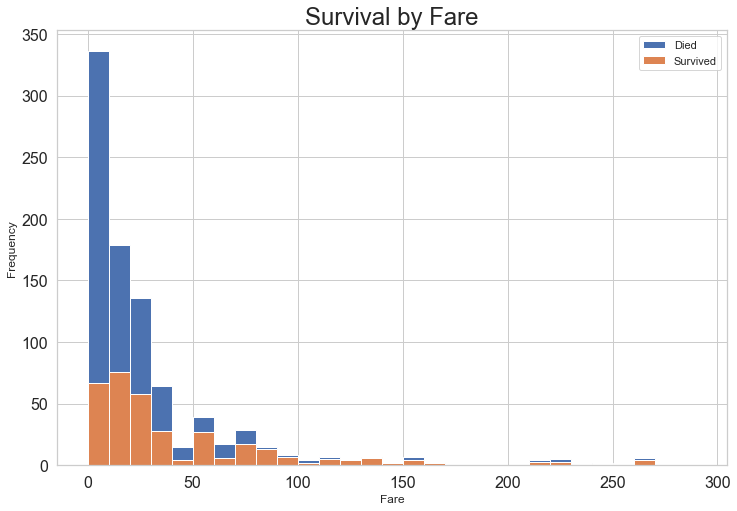

In [15]:
# Create a stacked histogram to show survival by age.
f, ax = plt.subplots(figsize=(12, 8))
titanic['Fare'].plot.hist(bins=range(0, 300, 10))
age_plot = titanic[titanic['Survived'] == 1]['Fare'].plot.hist(
    bins=range(0, 300, 10))
age_plot.legend(['Died', 'Survived'])
age_plot.set_title('Survival by Fare')
age_plot.set_xlabel('Fare')
plt.show()

### 3J.) Embarked

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


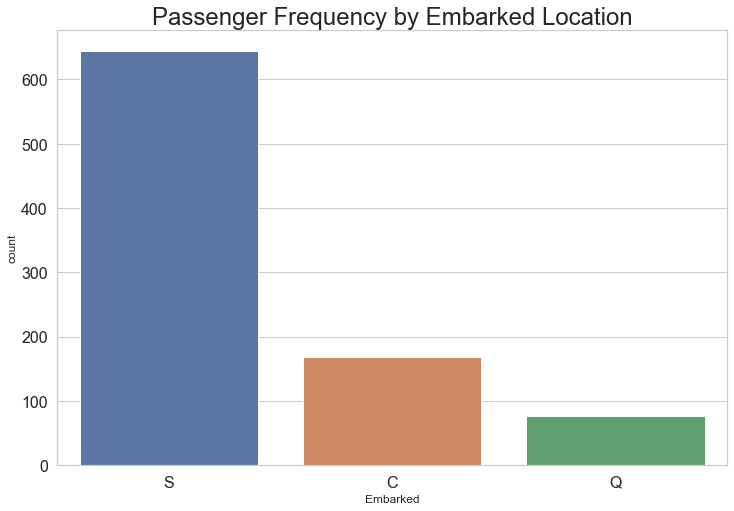

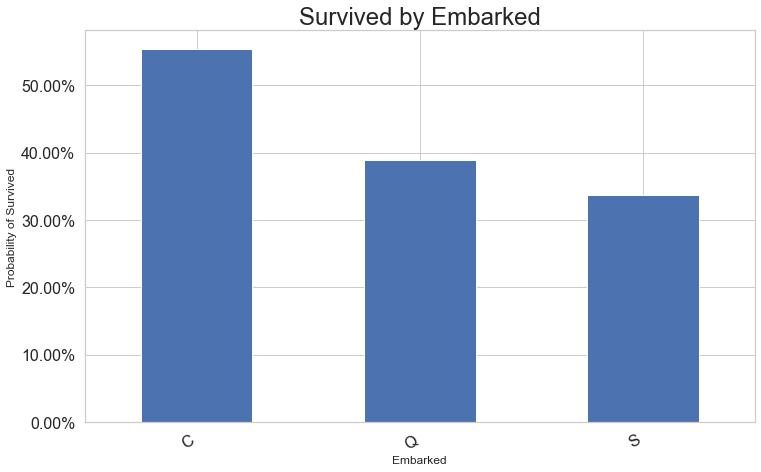

In [16]:
f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(
    titanic['Embarked']).set_title('Passenger Frequency by Embarked Location')
make_probability_chart(titanic, "Survived", "Embarked")

### 3K.) Ticket

In [17]:
titanic['Ticket_Frequency'] = titanic['Ticket'].map(
    titanic['Ticket'].value_counts())
test['Ticket_Frequency'] = test['Ticket'].map(test['Ticket'].value_counts())

## 4.) Filling in Missing Values

### 4A.) Figure out what is missing

In [18]:
print("Training Data")
print(titanic.isnull().sum())
print('\n')
print("Testing Data")
print(test.isnull().sum())

Training Data
PassengerId             0
Survived                0
Pclass                  0
Name                    0
Sex                     0
Age                   177
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                2
Salutation              0
Infant                  0
Child                   0
Elder                   0
Num_family_members      0
large_family            0
Deck                  687
Ticket_Frequency        0
dtype: int64


Testing Data
PassengerId             0
Pclass                  0
Name                    0
Sex                     0
Age                    86
SibSp                   0
Parch                   0
Ticket                  0
Fare                    1
Cabin                 327
Embarked                0
Salutation              0
Infant                  0
Child                   0
Elder                   0
Num_family_members      0
large_family          

### 4B.) Age

In [19]:
titanic['Age'].isnull().sum()  # Save for later.

177

### 4C.) Deck

In [20]:
# Replaced cabins with a space so they are dropped first.
titanic['Deck'] = titanic['Deck'].fillna(' ')
test['Deck'] = test['Deck'].fillna(' ')

# There is no deck 'T' on the Titanic, so replacing that with ' ':
titanic[titanic['Deck'] == 'T'] = titanic[titanic['Deck'] == 'T'].replace(
    'T', ' ')
test[test['Deck'] == 'T'] = test[test['Deck'] == 'T'].replace('T', ' ')

### 4D.) Fare

<AxesSubplot:>

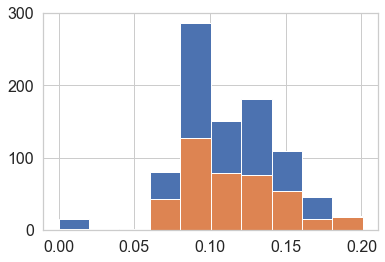

In [21]:
# Fill the one NA in test with the fare median
test['Fare'] = test['Fare'].fillna(test['Fare'].median())


def reshape_fare(x):
    if x <= 0:
        return 0
    else:
        return np.log1p(x)**.1 - 1


titanic['Fare_transformed'] = titanic['Fare'].apply(lambda x: reshape_fare(x))
test['Fare_transformed'] = test['Fare'].apply(lambda x: reshape_fare(x))

titanic['Fare_transformed'].hist()
test['Fare_transformed'].hist()

### 4E.) Embarked

In [22]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [23]:
# According to Encyclopedia Titanica, both of the null passengers embarked at Southampton.
# https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
titanic['Embarked'].fillna('S', inplace=True)

### 4F.) Sanity Check

In [24]:
# Sanity check to make sure all missing values are taken care of. Cabin won't be in any of the models, so we're good.
titanic.isnull().sum()
test.isnull().sum()

PassengerId             0
Pclass                  0
Name                    0
Sex                     0
Age                    86
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 327
Embarked                0
Salutation              0
Infant                  0
Child                   0
Elder                   0
Num_family_members      0
large_family            0
Deck                    0
Ticket_Frequency        0
Fare_transformed        0
dtype: int64

In [25]:
test.shape

(418, 20)

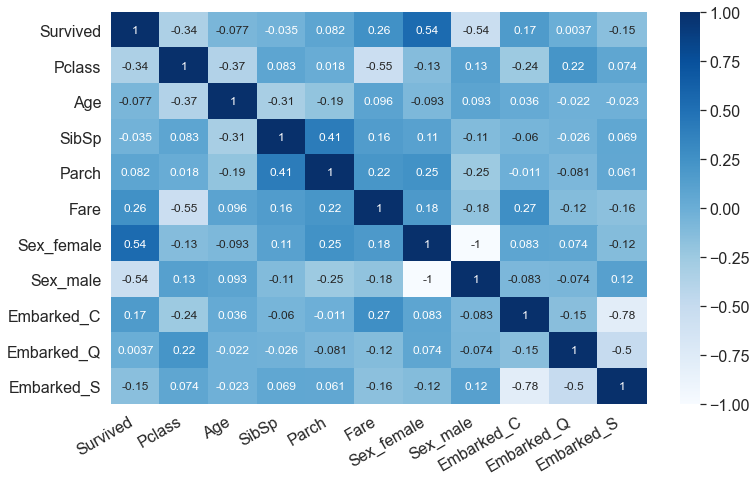

In [26]:
from sklearn.preprocessing import OneHotEncoder

original_variables = titanic[[
    'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'
]]
original_variables.head()

original_variables = pd.get_dummies(original_variables)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(original_variables.corr(), cmap='Blues', annot=True)
f.autofmt_xdate()

## 5.) Model Preparations

### 5A.) Engineer Features

In [27]:
print(titanic['Salutation'].value_counts())
titanic['Salutation'].replace('Dr', 'Mr', inplace=True)
titanic['Salutation'].replace('Rev', 'Mr', inplace=True)
titanic['Salutation'].replace('Major', 'Mr', inplace=True)
titanic['Salutation'].replace('Col', 'Mr', inplace=True)
titanic['Salutation'].replace('Mlle', 'Miss', inplace=True)
titanic['Salutation'].replace('Mme', 'Mrs', inplace=True)
titanic['Salutation'].replace('Capt', 'Mr', inplace=True)
titanic['Salutation'].replace('Countess', 'Mrs', inplace=True)
titanic['Salutation'].replace('Ms', 'Miss', inplace=True)
titanic['Salutation'].replace('Sir', 'Mr', inplace=True)
titanic['Salutation'].replace('Jonkheer', 'Mr', inplace=True)
titanic['Salutation'].replace('Don', 'Mr', inplace=True)
titanic['Salutation'].replace('Dona', 'Mrs', inplace=True)
titanic['Salutation'].replace('Lady', 'Mrs', inplace=True)

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Mme           1
Countess      1
Don           1
Jonkheer      1
Ms            1
Sir           1
Capt          1
Lady          1
Name: Salutation, dtype: int64


### 5B.) Drop Columns

In [28]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         891 non-null    int64  
 1   Survived            891 non-null    int64  
 2   Pclass              891 non-null    int64  
 3   Name                891 non-null    object 
 4   Sex                 891 non-null    object 
 5   Age                 714 non-null    float64
 6   SibSp               891 non-null    int64  
 7   Parch               891 non-null    int64  
 8   Ticket              891 non-null    object 
 9   Fare                891 non-null    float64
 10  Cabin               204 non-null    object 
 11  Embarked            891 non-null    object 
 12  Salutation          891 non-null    object 
 13  Infant              891 non-null    bool   
 14  Child               891 non-null    bool   
 15  Elder               891 non-null    bool   
 16  Num_fami

In [29]:
print(test['Salutation'].value_counts())
test['Salutation'].replace('Dr', 'Mr', inplace=True)
test['Salutation'].replace('Rev', 'Mr', inplace=True)
test['Salutation'].replace('Major', 'Mr', inplace=True)
test['Salutation'].replace('Col', 'Mr', inplace=True)
test['Salutation'].replace('Mlle', 'Miss', inplace=True)
test['Salutation'].replace('Mme', 'Mrs', inplace=True)
test['Salutation'].replace('Capt', 'Mr', inplace=True)
test['Salutation'].replace('Countess', 'Mrs', inplace=True)
test['Salutation'].replace('Ms', 'Miss', inplace=True)
test['Salutation'].replace('Sir', 'Mr', inplace=True)
test['Salutation'].replace('Jonkheer', 'Mr', inplace=True)
test['Salutation'].replace('Don', 'Mr', inplace=True)
test['Salutation'].replace('Dona', 'Mrs', inplace=True)
test['Salutation'].replace('Lady', 'Mrs', inplace=True)

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Ms          1
Dr          1
Name: Salutation, dtype: int64


In [30]:
# Dropping columns not needed in the model.
X_train = titanic.drop([
    'Survived', 'PassengerId', 'Name', 'Cabin', 'Ticket', 'Num_family_members'
], 1)  # 1 is to specify columns
y_train = titanic['Survived']
X_test = test.drop(
    ['PassengerId', 'Cabin', 'Name', 'Ticket', 'Num_family_members'], 1)

In [31]:
X_train['Pclass'] = X_train['Pclass'].astype("category")
X_test['Pclass'] = X_train['Pclass'].astype("category")

### 5C.) Add Dummy Variables

In [32]:
# Fit and transform categorical variables to integers
X = pd.get_dummies(X_train,
                   columns=['Pclass', 'Sex', 'Embarked', 'Deck', 'Salutation'])
X_test = pd.get_dummies(
    X_test, columns=['Pclass', 'Sex', 'Embarked', 'Deck', 'Salutation'])
column_names = list(X.columns)

In [33]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()
X = pd.DataFrame(imputer.fit_transform(X), columns=column_names)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=column_names)

In [34]:
y = titanic['Survived']
logreg_sm = sm.Logit(y.astype(float), X.astype(float)).fit()
print(logreg_sm.summary())

         Current function value: 0.391446
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      865
Method:                           MLE   Df Model:                           25
Date:                Sat, 20 Feb 2021   Pseudo R-squ.:                  0.4122
Time:                        11:25:07   Log-Likelihood:                -348.78
converged:                      False   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.394e-87
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Age                  -0.0194      0.014     -1.430      0.153      -0.046       0.007
SibSp                -0.3258      0.180     

C:\Users\Tom\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [35]:
X['large_family'] = X['large_family'].map({False: 0, True: 1})
X_test['large_family'] = X_test['large_family'].map({False: 0, True: 1})
X['Child'] = X['Child'].map({False: 0, True: 1})
X_test['Child'] = X_test['Child'].map({False: 0, True: 1})
X['Elder'] = X['Elder'].map({False: 0, True: 1})
X_test['Elder'] = X['Elder'].map({False: 0, True: 1})

### 5D.) Check for Multicolinearity

In [36]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]

print(vif_data)

              feature       VIF
0                 Age  3.404549
1               SibSp  2.844945
2               Parch  2.308213
3                Fare  2.567797
4              Infant  1.307128
5               Child  2.123565
6               Elder  1.707751
7        large_family  3.633758
8    Ticket_Frequency  2.837618
9    Fare_transformed  4.181137
10           Pclass_1       inf
11           Pclass_2       inf
12           Pclass_3       inf
13         Sex_female       inf
14           Sex_male       inf
15         Embarked_C       inf
16         Embarked_Q       inf
17         Embarked_S       inf
18             Deck_        inf
19             Deck_A       inf
20             Deck_B       inf
21             Deck_C       inf
22             Deck_D       inf
23             Deck_E       inf
24             Deck_F       inf
25             Deck_G       inf
26  Salutation_Master       inf
27    Salutation_Miss       inf
28      Salutation_Mr       inf
29     Salutation_Mrs       inf


C:\Users\Tom\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [37]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_test.columns

# calculating VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(X_test.values, i)
    for i in range(len(X_test.columns))
]

print(vif_data)

              feature       VIF
0                 Age  2.204762
1               SibSp  2.431532
2               Parch  1.492451
3                Fare  3.683451
4              Infant  1.032802
5               Child  1.809134
6               Elder  1.070322
7        large_family  2.017802
8    Ticket_Frequency  2.095433
9    Fare_transformed  3.859759
10           Pclass_1       inf
11           Pclass_2       inf
12           Pclass_3       inf
13         Sex_female       inf
14           Sex_male       inf
15         Embarked_C       inf
16         Embarked_Q       inf
17         Embarked_S       inf
18             Deck_        inf
19             Deck_A       inf
20             Deck_B       inf
21             Deck_C       inf
22             Deck_D       inf
23             Deck_E       inf
24             Deck_F       inf
25             Deck_G       inf
26  Salutation_Master       inf
27    Salutation_Miss       inf
28      Salutation_Mr       inf
29     Salutation_Mrs       inf


C:\Users\Tom\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [38]:
X = X.drop([
    'Fare', 'Salutation_Mr', 'Deck_ ', 'Sex_female', 'Embarked_C', 'Pclass_3'
], 1)
X_test = X_test.drop([
    'Fare', 'Salutation_Mr', 'Deck_ ', 'Sex_female', 'Embarked_C', 'Pclass_3'
], 1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]

print(vif_data)

              feature        VIF
0                 Age  19.632343
1               SibSp   3.431632
2               Parch   2.820692
3              Infant   1.326757
4               Child   2.472190
5               Elder   1.762271
6        large_family   3.894279
7    Ticket_Frequency   7.586870
8    Fare_transformed  38.970452
9            Pclass_1   7.285089
10           Pclass_2   1.772905
11           Sex_male  27.607643
12         Embarked_Q   1.700882
13         Embarked_S   5.563804
14             Deck_A   1.327070
15             Deck_B   2.003158
16             Deck_C   2.224047
17             Deck_D   1.535479
18             Deck_E   1.425891
19             Deck_F   1.053953
20             Deck_G   1.042479
21  Salutation_Master   1.877572
22    Salutation_Miss   9.504446
23     Salutation_Mrs   7.991390


In [39]:
assert len(X_test.columns) == len(X.columns)
column_names = list(X.columns)

### 5E.) Normalizing Features

In [40]:
X = StandardScaler().fit_transform(X)
X_test = StandardScaler().fit_transform(X_test)

### 5F.)  Split Titanic Data into Training and Validation Model

In [41]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, titanic['Survived'], test_size=0.2, random_state=42)

## 6.) Modeling and Verifying Model

### 6A.) Logistic Regression

In [42]:
logreg = LogisticRegression(max_iter=10000,
                            penalty='l2',
                            class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_validation)
print(classification_report(y_validation, y_pred_log))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict(X_validation)
y_pred_proba = logreg.predict_proba(X_validation)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)

print("Accuracy score:", accuracy_score(y_validation, y_pred_prob))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       105
           1       0.75      0.81      0.78        74

    accuracy                           0.81       179
   macro avg       0.80      0.81      0.81       179
weighted avg       0.81      0.81      0.81       179

Accuracy score: 0.8100558659217877


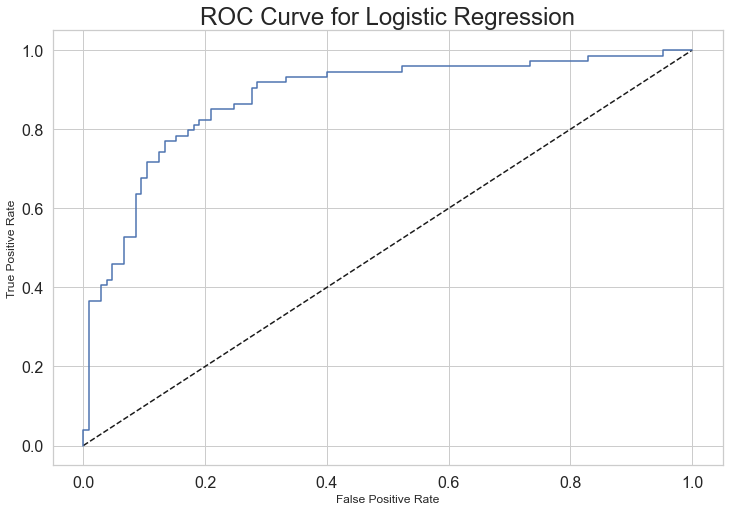

In [43]:
make_roc_auc_chart("Logistic Regression", y_validation, y_pred_proba)

Hyperparameter tuning: Logistic Regression

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    3.2s finished


              precision    recall  f1-score   support

           0       0.87      0.81      0.84       105
           1       0.75      0.82      0.79        74

    accuracy                           0.82       179
   macro avg       0.81      0.82      0.81       179
weighted avg       0.82      0.82      0.82       179

Accuracy score: 0.8156424581005587


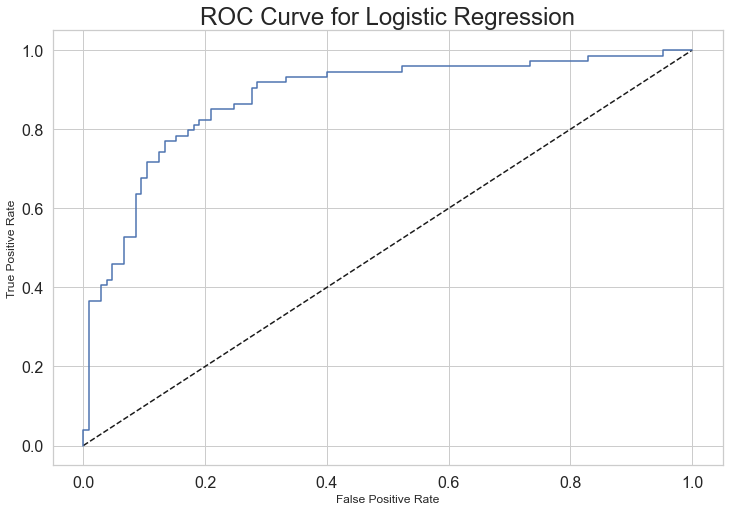

In [44]:
# Create the parameter grid
lr = LogisticRegression(max_iter=10000, class_weight='balanced')
param_grid = {
    'C': [.01, .03, .1, .3, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000]
}  # Harmonic mean

logreg_cv = GridSearchCV(estimator=lr,
                         param_grid=param_grid,
                         n_jobs=-1,
                         verbose=5,
                         return_train_score=True,
                         cv=5,
                         scoring='roc_auc')
y_pred_gridsearch = logreg_cv.fit(X_train, y_train).predict(X_validation)
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)
print(classification_report(y_validation, y_pred_gridsearch))
print("Accuracy score:", accuracy_score(y_validation, y_pred_gridsearch))
make_roc_auc_chart("Logistic Regression", y_validation, y_pred_proba)

In [45]:
print(logreg_cv.fit(X, y).predict(X_test).sum())
assert logreg_cv.fit(X, y).predict(X_test).sum() < 200

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s


182
Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Done  58 out of  65 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    0.4s finished


### 6B.) Random Forest

In [46]:
random_forest = RandomForestClassifier(n_estimators=1000, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_validation)
print(classification_report(y_validation, y_pred_rf))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = random_forest.predict(X_validation)
y_pred_proba = random_forest.predict_proba(X_validation)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)

print("Accuracy score:", accuracy_score(y_validation, y_pred_prob))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       105
           1       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Accuracy score: 0.8100558659217877


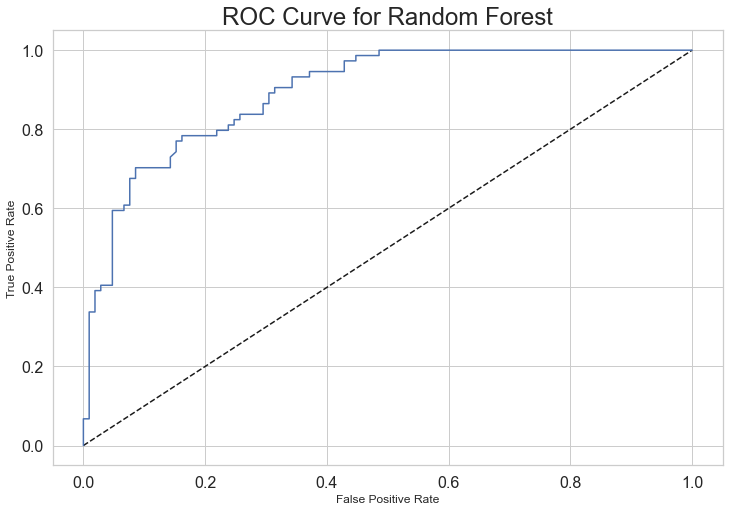

In [47]:
plt.figure(figsize=(12, 8))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

In [48]:
# Create the parameter grid
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100],
    'max_depth': [x for x in range(3, 10)],
    'min_samples_leaf': [x for x in range(3, 20)],
    'max_features': ['sqrt', 'log2', .2]
}

rf_cv = GridSearchCV(rf,
                     param_grid=param_grid,
                     cv=5,
                     n_jobs=-1,
                     scoring='roc_auc',
                     verbose=5)

y_pred_gridsearch = rf_cv.fit(X_train, y_train).predict(X_validation)
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)
print(classification_report(y_validation, y_pred_gridsearch))
print("Accuracy score:", accuracy_score(y_validation, y_pred_gridsearch))

Fitting 5 folds for each of 357 candidates, totalling 1785 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1785 out of 1785 | elapsed:  2.9min finished


              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179

Accuracy score: 0.8156424581005587


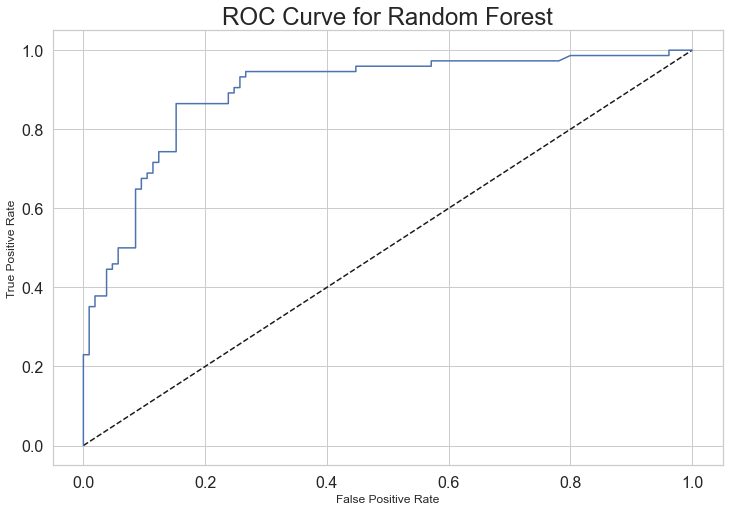

In [49]:
y_pred_proba = rf_cv.predict_proba(X_validation)[:, 1]
make_roc_auc_chart("Random Forest", y_validation, y_pred_proba)

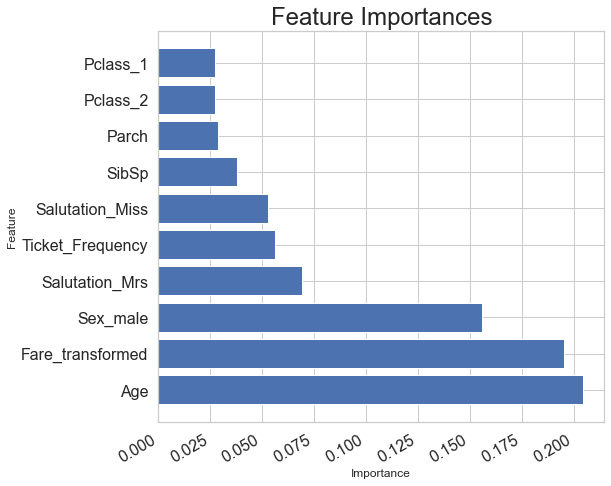

In [50]:
feature_importances = pd.DataFrame(
    zip(list(column_names), random_forest.feature_importances_),
    columns=("Feature", "Importance")).sort_values(by="Importance",
                                                   ascending=False)[0:10]
f, ax = plt.subplots(figsize=(8, 8))
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
f.autofmt_xdate()
plt.show()

### 6C.) K-Nearest Neighbors 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.3s finished


              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

Accuracy score: 0.8212290502793296


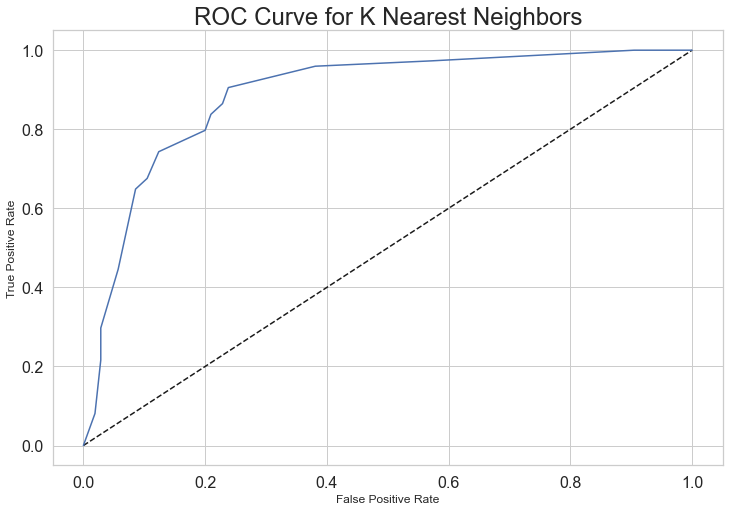

In [51]:
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]}
knn = sklearn.neighbors.KNeighborsClassifier()
knn_gridsearch = GridSearchCV(knn,
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=5,
                              return_train_score=True,
                              cv=5)
y_pred = knn_gridsearch.fit(X_train, y_train).predict(X_validation)
y_pred_proba = knn_gridsearch.predict_proba(X_validation)[:, 1]
# Generate ROC curve values: fpr, tpr, thresholds

fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
print(classification_report(y_validation, y_pred))
print("Accuracy score:", accuracy_score(y_validation, y_pred))
make_roc_auc_chart("K Nearest Neighbors", y_validation, y_pred_proba)

In [52]:
knn_gridsearch.best_params_

{'n_neighbors': 15}

### 6D.) Gradient Boosting Classifier

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.8min finished


              precision    recall  f1-score   support

           0       0.84      0.84      0.84       105
           1       0.77      0.77      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Accuracy score: 0.8100558659217877


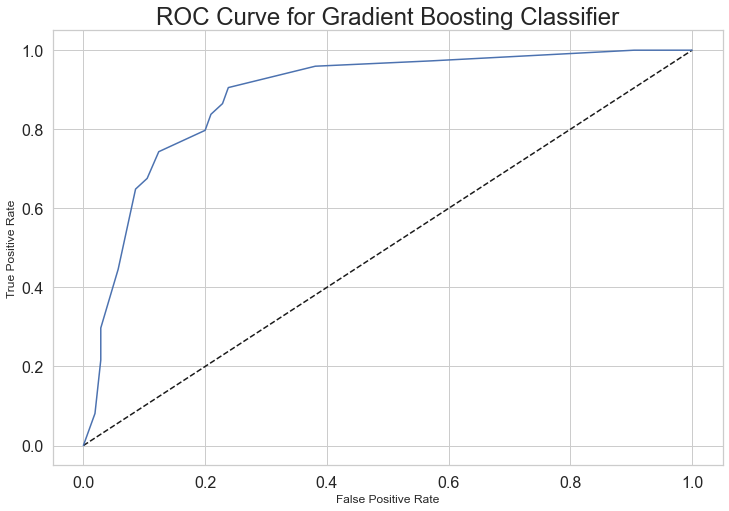

In [53]:
param_grid = {
    'learning_rate': np.linspace(.01, .3, 30),
    'max_depth': [x for x in range(2, 20)],
    'n_estimators': [100],
    'max_features': [.2, 'sqrt', 'log2'],
    'warm_start': [True]
}
gbm = GradientBoostingClassifier()
gbm_random_search = RandomizedSearchCV(gbm,
                                       param_distributions=param_grid,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       verbose=5,
                                       n_iter=100,
                                       cv=5,
                                       return_train_score=True)

predictions = gbm_random_search.fit(X_train, y_train).predict(X_validation)
fpr, tpr, thresholds = roc_curve(y_validation, predictions)
print(classification_report(y_validation, predictions))
print("Accuracy score:", accuracy_score(y_validation, predictions))
make_roc_auc_chart("Gradient Boosting Classifier", y_validation, y_pred_proba)

## 6E.) Linear SVC

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  40 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.4s finished


              precision    recall  f1-score   support

           0       0.82      0.85      0.83       105
           1       0.77      0.73      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

Accuracy score: 0.7988826815642458


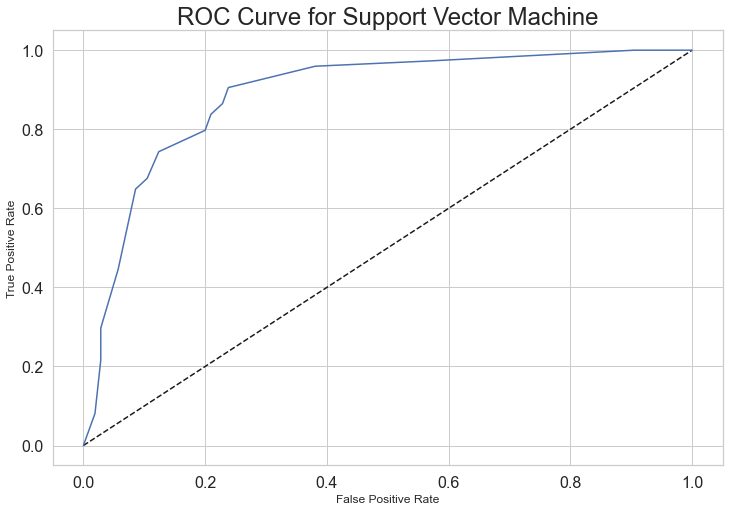

In [54]:
from sklearn.svm import SVC
param_grid = {'C': [.01, .03, .1, .3, 1, 3, 10, 30]}
svc = SVC(kernel='rbf')
svc_cv = GridSearchCV(estimator=svc,
                      param_grid=param_grid,
                      n_jobs=-1,
                      verbose=5,
                      return_train_score=True,
                      cv=5,
                      scoring='roc_auc')

predictions = svc_cv.fit(X_train, y_train).predict(X_validation)
fpr, tpr, thresholds = roc_curve(y_validation, predictions)

print(classification_report(y_validation, predictions))
print("Accuracy score:", accuracy_score(y_validation, predictions))
make_roc_auc_chart("Support Vector Machine", y_validation, y_pred_proba)

## 6F.) XGBoost

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4780 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 6280 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  3.6min finished


              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

Accuracy score: 0.8268156424581006


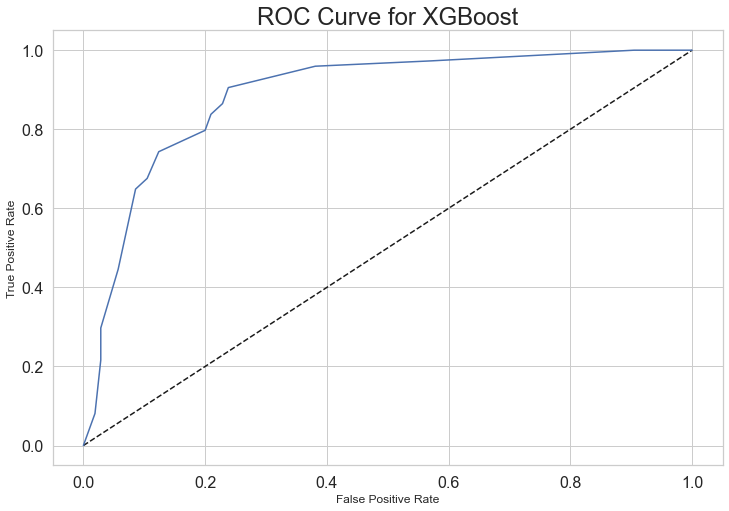

In [55]:
# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100)

# Create the parameter grid: gbm_param_grid
xgb_param_grid = {
    'colsample_bytree': np.arange(.3, .7, .05),
    'n_estimators': [100],
    'max_depth': np.arange(2, 20),
    'eta': [.001, .003, .001, .003, .01, .03, .1, .3, 1]
}

# Perform grid search: grid_mse
xgb_cv = GridSearchCV(param_grid=xgb_param_grid,
                      estimator=xg_cl,
                      scoring="roc_auc",
                      cv=5,
                      verbose=1,
                      n_jobs=-1)

predictions = xgb_cv.fit(X_train, y_train).predict(X_validation)
fpr, tpr, thresholds = roc_curve(y_validation, predictions)

print(classification_report(y_validation, predictions))
print("Accuracy score:", accuracy_score(y_validation, predictions))
make_roc_auc_chart("XGBoost", y_validation, y_pred_proba)

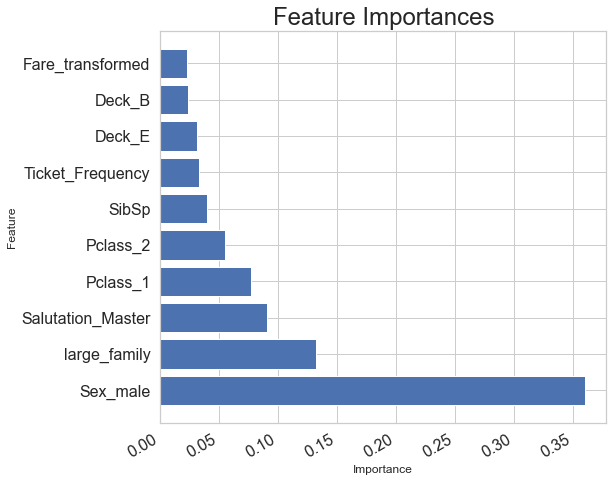

In [65]:

feature_importances = pd.DataFrame(
    zip(list(column_names), xg_cl.feature_importances_),
    columns=("Feature", "Importance")).sort_values(by="Importance",
                                                   ascending=False)[0:10]
f, ax = plt.subplots(figsize=(8, 8))
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
f.autofmt_xdate()
plt.show()

In [56]:
print(logreg_cv.best_params_)
print(rf_cv.best_params_)
print(knn_gridsearch.best_params_)
print(gbm_random_search.best_params_)
print(svc_cv.best_params_)
print(xgb_cv.best_params_)

{'C': 0.03}
{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 100}
{'n_neighbors': 15}
{'warm_start': True, 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 2, 'learning_rate': 0.27999999999999997}
{'C': 3}
{'colsample_bytree': 0.35, 'eta': 0.03, 'max_depth': 13, 'n_estimators': 100}


## 7.) Conclusion

In [57]:
classifier1 = LogisticRegression(C=logreg_cv.best_params_['C'], max_iter=10000)
classifier2 = RandomForestClassifier(
    max_depth=rf_cv.best_params_['max_depth'],
    min_samples_leaf=rf_cv.best_params_['min_samples_leaf'],
    max_features=rf_cv.best_params_['max_features'],
    n_estimators=2000,
    random_state=42)
classifier3 = KNeighborsClassifier(
    n_neighbors=knn_gridsearch.best_params_['n_neighbors'])
classifier4 = GradientBoostingClassifier(
    n_estimators=2000,
    max_features=gbm_random_search.best_params_['max_features'],
    max_depth=gbm_random_search.best_params_['max_depth'],
    learning_rate=gbm_random_search.best_params_['learning_rate'],
    random_state=42)
classifier5 = SVC(C=svc_cv.best_params_['C'])
classifier6 = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=2000,
    colsample_bytree=xgb_cv.best_params_['colsample_bytree'],
    eta=xgb_cv.best_params_['eta'],
    max_depth=xgb_cv.best_params_['max_depth'])
sclf = StackingClassifier(estimators=[(
    'logreg', classifier1), ('rf', classifier2), (
        'knn',
        classifier3), ('gbm',
                       classifier4), ('svc',
                                      classifier5), ('xgb', classifier6)]).fit(
                                          X, titanic['Survived'])
final_predictions = sclf.fit(X, y).predict(X_test)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  4.1min finished


              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Accuracy score: 0.8100558659217877


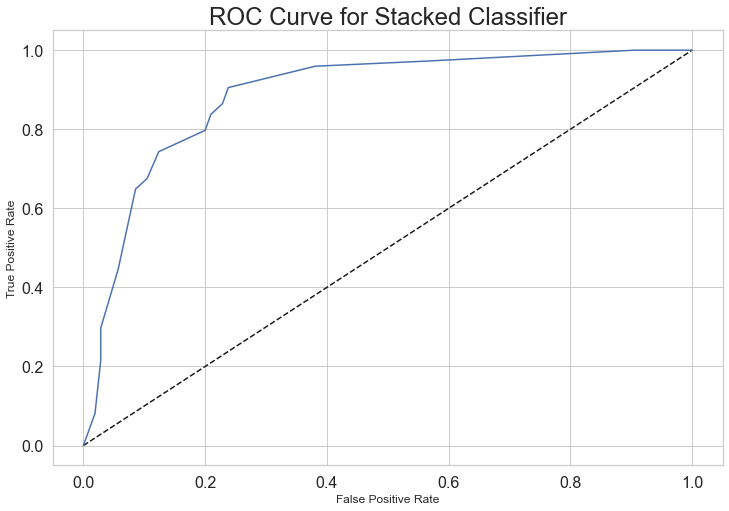

In [58]:
y_sclf = sclf.fit(X_train, y_train).predict(X_validation)
y_sclf_proba = sclf.fit(X_train, y_train).predict_proba(X_validation)[:, 1]
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_sclf_proba)
print(classification_report(y_validation, y_sclf))
print("Accuracy score:", accuracy_score(y_validation, y_sclf))

make_roc_auc_chart("Stacked Classifier", y_validation, y_pred_proba)

In [59]:
pd.DataFrame(final_predictions,
             index=test['PassengerId'],
             columns=['Survived']).to_csv("Predictions.csv")

In [60]:
final_predictions.sum() / len(final_predictions)

0.35406698564593303

In [61]:
print(logreg_cv.fit(X, y).predict(X_test).sum())
print(rf.fit(X, y).predict(X_test).sum())
print(knn.fit(X, y).predict(X_test).sum())
print(gbm.fit(X, y).predict(X_test).sum())
print(svc.fit(X, y).predict(X_test).sum())
print(xg_cl.fit(X, y).predict(X_test).sum())
print(final_predictions.sum())

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    0.5s finished


182
133
174
156
181
132
148
